In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, RocCurveDisplay, auc, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Read the data

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


# Drop unnecessary columns

In [ ]:
df.drop(["Unnamed: 0", "id"], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,103904.0,39.379706,15.114964,7.0,27.0,40.0,51.0,85.0
Flight Distance,103904.0,1189.448375,997.147281,31.0,414.0,843.0,1743.0,4983.0
Inflight wifi service,103904.0,2.729683,1.327829,0.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,103904.0,3.060296,1.525075,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,103904.0,2.756901,1.398929,0.0,2.0,3.0,4.0,5.0
Gate location,103904.0,2.976883,1.277621,0.0,2.0,3.0,4.0,5.0
Food and drink,103904.0,3.202129,1.329533,0.0,2.0,3.0,4.0,5.0
Online boarding,103904.0,3.250375,1.349509,0.0,2.0,3.0,4.0,5.0
Seat comfort,103904.0,3.439396,1.319088,0.0,2.0,4.0,5.0,5.0
Inflight entertainment,103904.0,3.358158,1.332991,0.0,2.0,4.0,4.0,5.0


# Control missing values

In [ ]:
df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

## Fill missing values with mean

In [ ]:
df["Arrival Delay in Minutes"].fillna(df["Arrival Delay in Minutes"].mean(), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

# Categorical variable unique values

In [ ]:
print("Gender: ", df["Gender"].unique())
print("Customer Type: ", df["Customer Type"].unique())
print("Type of Travel: ", df["Type of Travel"].unique())
print("Class: ", df["Class"].unique())
print("Satisfaction: ", df["satisfaction"].unique())

Gender:  ['Male' 'Female']
Customer Type:  ['Loyal Customer' 'disloyal Customer']
Type of Travel:  ['Personal Travel' 'Business travel']
Class:  ['Eco Plus' 'Business' 'Eco']
Satisfaction:  ['neutral or dissatisfied' 'satisfied']


In [ ]:
print(df["Gender"].value_counts(), "\n")
print(df["Customer Type"].value_counts(), "\n")
print(df["Type of Travel"].value_counts(), "\n")
print(df["Class"].value_counts(), "\n")
print(df["satisfaction"].value_counts())

Female    52727
Male      51177
Name: Gender, dtype: int64 

Loyal Customer       84923
disloyal Customer    18981
Name: Customer Type, dtype: int64 

Business travel    71655
Personal Travel    32249
Name: Type of Travel, dtype: int64 

Business    49665
Eco         46745
Eco Plus     7494
Name: Class, dtype: int64 

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64


## Categorical variable to numeric variable

In [ ]:
df['Gender'] = df['Gender'].map({'Female':1, 'Male':0})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Business travel':1, 'Personal Travel':0})
df['Class'] = df['Class'].map({'Business':2, 'Eco Plus':1,'Eco':0})
df['satisfaction'] = df['satisfaction'].map({'satisfied':1, 'neutral or dissatisfied':0})

In [ ]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,1,2,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,1,2,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,1,2,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,1,2,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


# Correlation Matrix

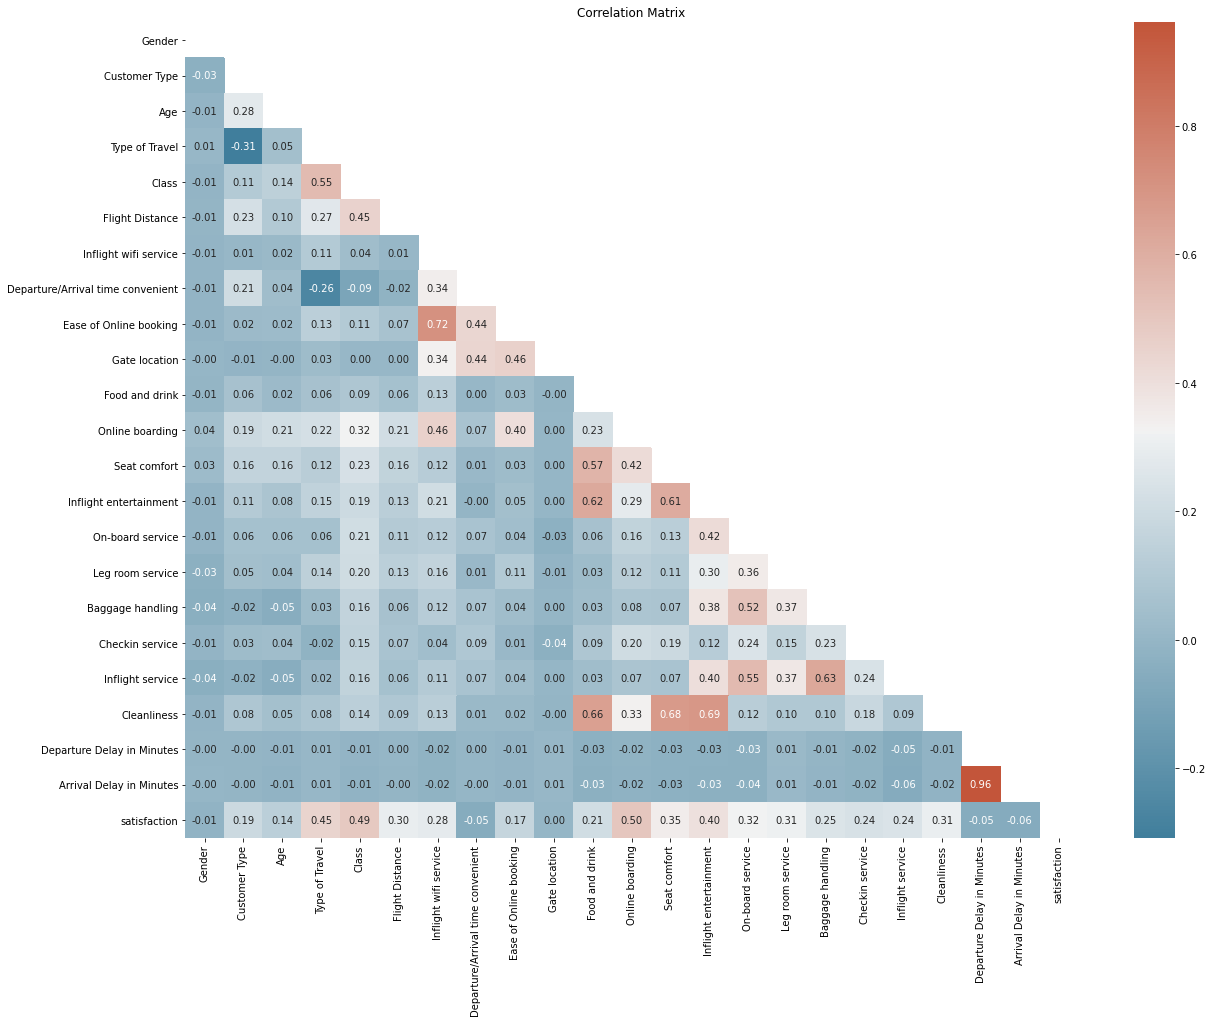

In [ ]:
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(20, 15));
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, fmt = ".2f",  annot = True)
plt.title("Correlation Matrix")
plt.show()

## Delete highly correlated columns

In [ ]:
corr_matrix = correlation_matrix.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df.drop(to_drop, axis=1, inplace=True)
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0
1,0,0,25,1,2,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,0
2,1,1,26,1,2,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1
3,1,1,25,1,2,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,0
4,0,1,61,1,2,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1


## Delete low correlated columns with satisfaction

In [ ]:
df.drop(["Gate location"], axis=1, inplace=True)

# Control duplicated values

In [ ]:
df.duplicated().sum()

0

# Plots

## Balanced or unbalanced data check

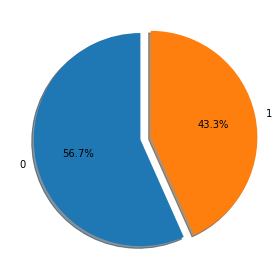

In [ ]:
labels = df["satisfaction"].unique()
counts = (df["satisfaction"].value_counts() / df.shape[0]) * 100
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1)  
plt.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

## History plots of Age and Departure Delay in Minutes

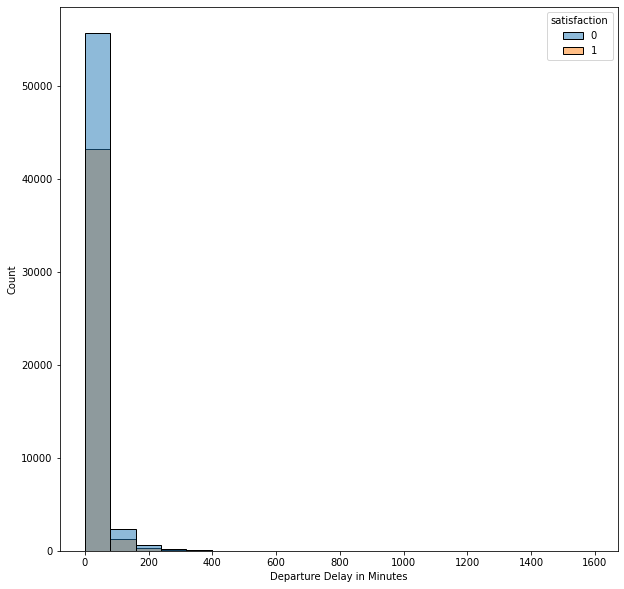

In [ ]:
plt.figure(figsize = (10,10))
sns.histplot(x = "Departure Delay in Minutes", hue="satisfaction", bins=20, data = df);

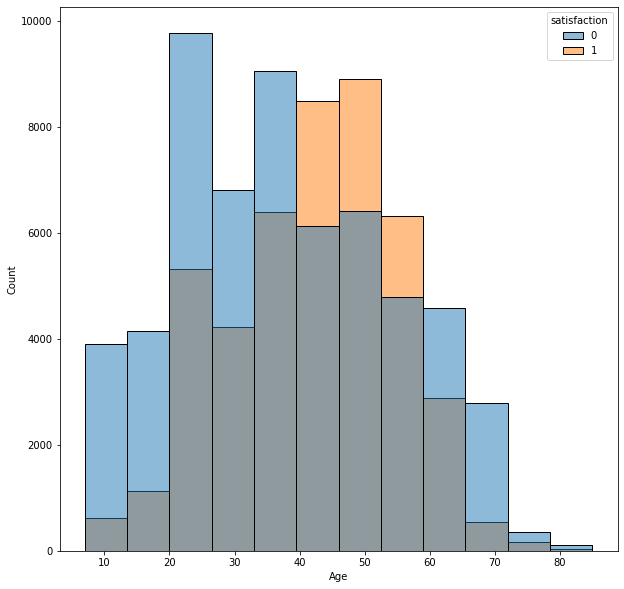

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(x = "Age", hue="satisfaction", bins=12, data = df);

## Pairplots

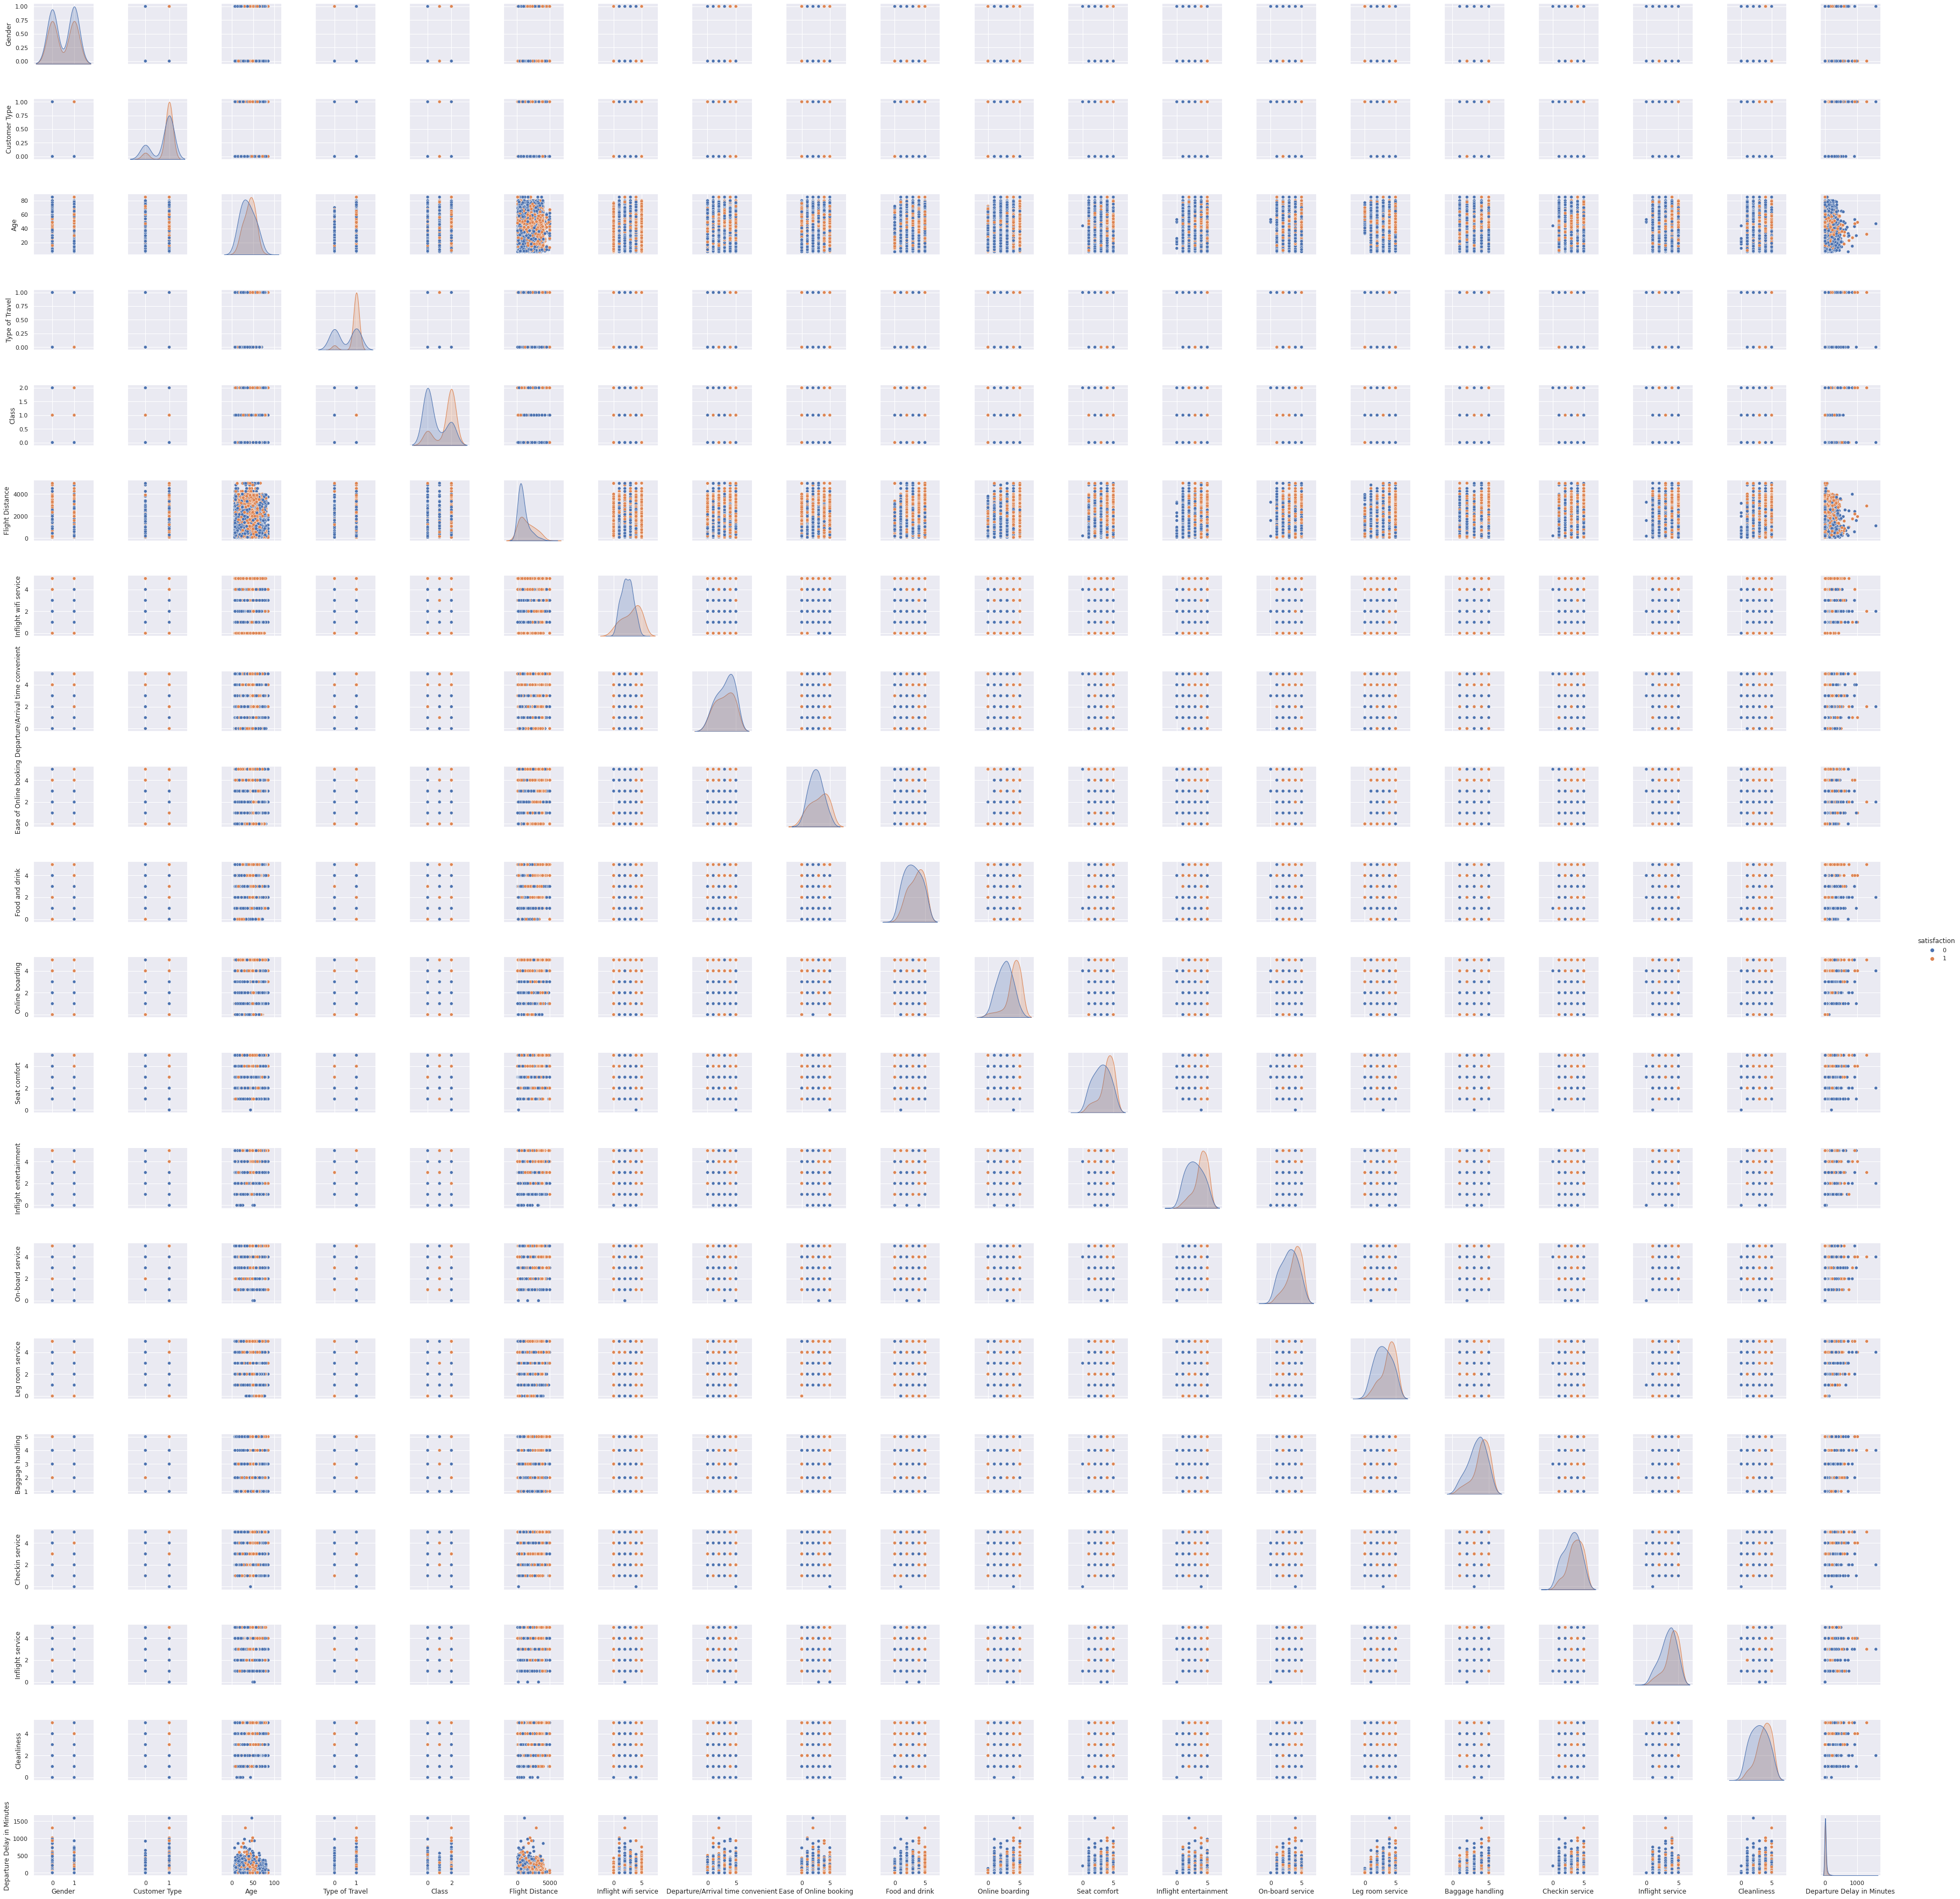

In [ ]:
sns.pairplot(df, hue = "satisfaction", diag_kws={'bw': 0.5})

## Kernel Density Estimation Plot

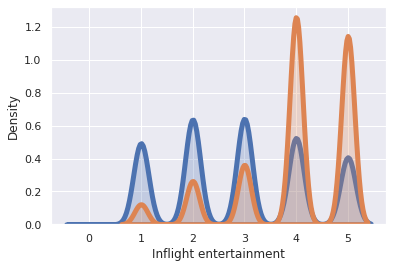

In [ ]:
sns.set(style="darkgrid")
sns.kdeplot(df[df.satisfaction == 0]["Inflight entertainment"], shade = True, linewidth = 5)
sns.kdeplot(df[df.satisfaction == 1]["Inflight entertainment"], shade = True, linewidth = 5);

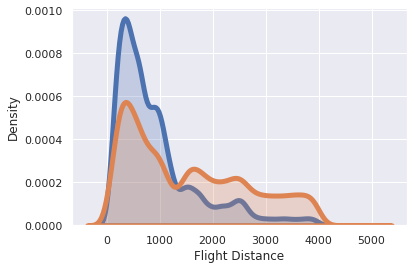

In [ ]:
sns.set(style="darkgrid")
sns.kdeplot(df[df.satisfaction == 0]["Flight Distance"], shade = True, linewidth = 5)
sns.kdeplot(df[df.satisfaction == 1]["Flight Distance"], shade = True, linewidth = 5);

## Count plots

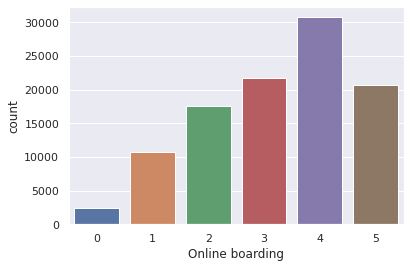

In [ ]:
sns.countplot(df["Online boarding"]);

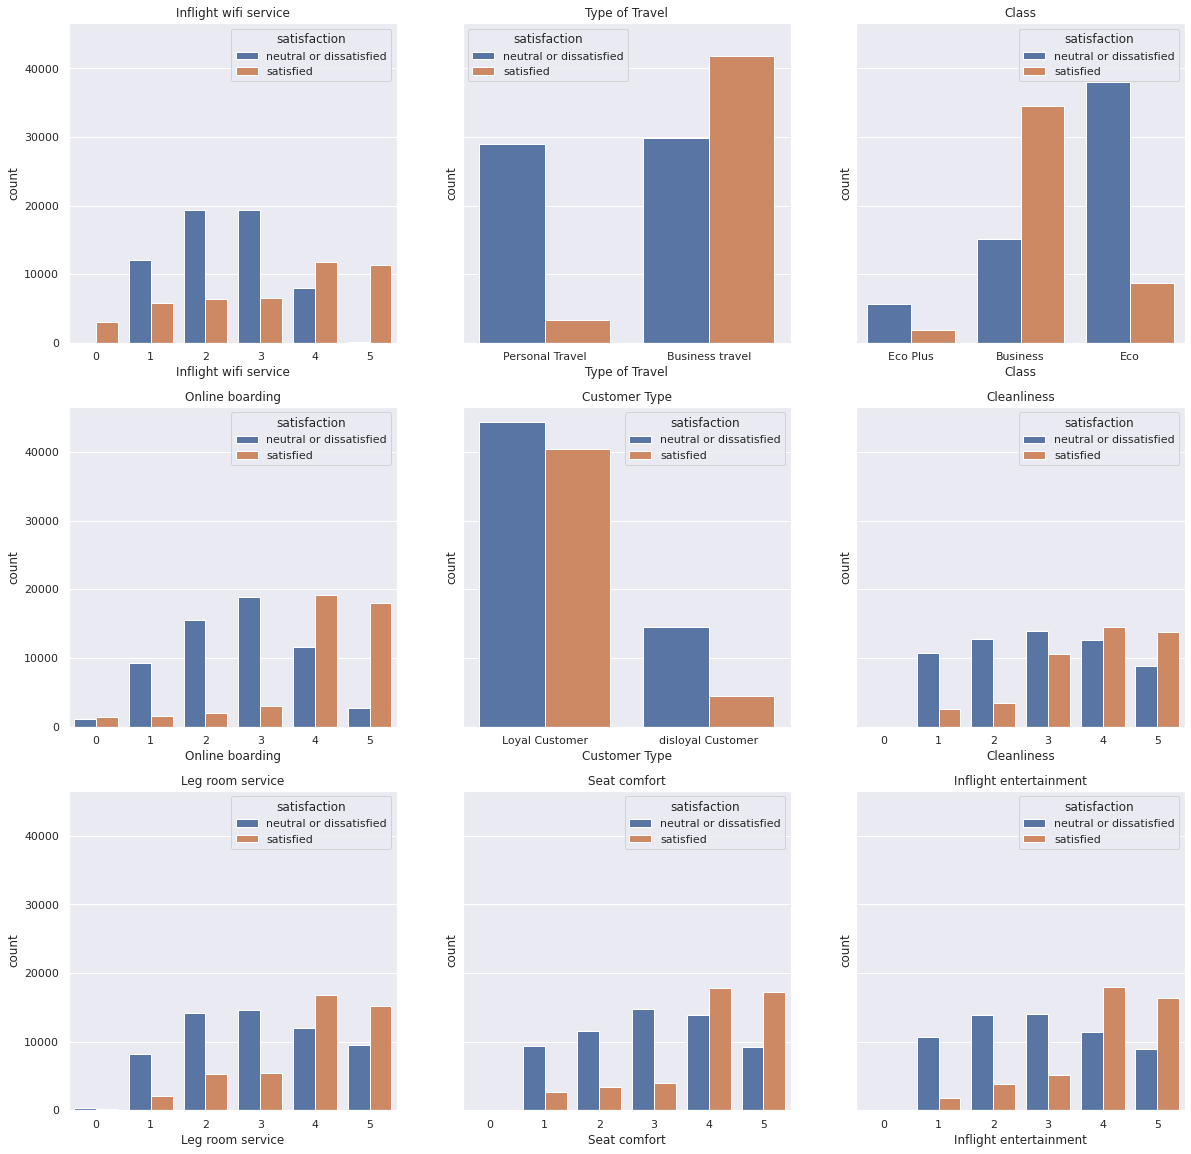

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,20), sharey=True)

# axes iki boyutlu bir matris olarak döndürülüyor
# sol üst eksene plot çizdirelim
sns.countplot(df["Inflight wifi service"], ax=axes[0][0], hue=df["satisfaction"]);
axes[0][0].set_title("Inflight wifi service");

# sağ üst eksene scatter çizdirelim
axes[0][1] = sns.countplot(df["Type of Travel"], hue=df["satisfaction"], ax=axes[0][1]);
axes[0][1].set_title("Type of Travel");

# sağ üst eksene scatter çizdirelim
axes[0][2] = sns.countplot(df["Class"], hue=df["satisfaction"], ax=axes[0][2]);
axes[0][2].set_title("Class");

# sol alt eksene x histogram, sağ alt eksene y histogram
axes[1][0] = sns.countplot(df["Online boarding"], ax=axes[1][0], hue=df["satisfaction"]);
axes[1][0].set_title("Online boarding");
axes[1][1] = sns.countplot(df["Customer Type"], ax=axes[1][1], hue=df["satisfaction"]);
axes[1][1].set_title("Customer Type");
axes[1][2] = sns.countplot(df["Cleanliness"], ax=axes[1][2], hue=df["satisfaction"]);
axes[1][2].set_title("Cleanliness");

# sol alt eksene x histogram, sağ alt eksene y histogram
axes[2][0] = sns.countplot(df["Leg room service"], ax=axes[2][0], hue=df["satisfaction"]);
axes[2][0].set_title("Leg room service");
axes[2][1] = sns.countplot(df["Seat comfort"], ax=axes[2][1], hue=df["satisfaction"]);
axes[2][1].set_title("Seat comfort");
axes[2][2] = sns.countplot(df["Inflight entertainment"], ax=axes[2][2], hue=df["satisfaction"]);
axes[2][2].set_title("Inflight entertainment");
plt.show()

## Boxplot of features

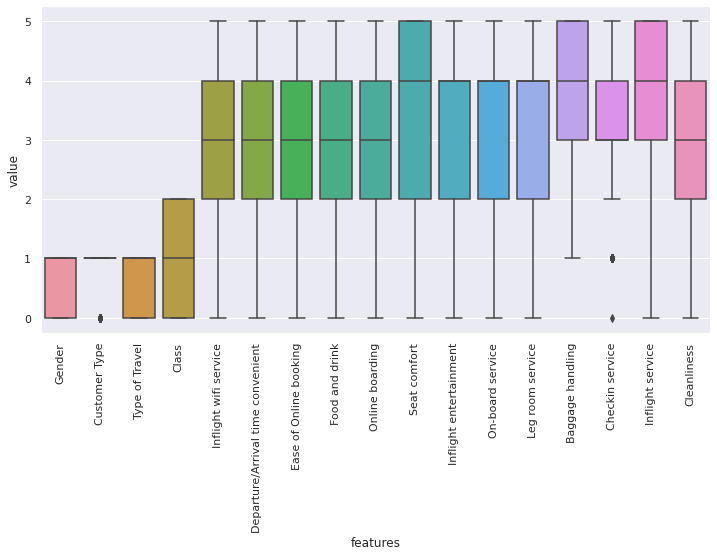

In [ ]:
data_melted = pd.melt(df.drop(["Departure Delay in Minutes", "Age", "Flight Distance"], axis=1),id_vars = "satisfaction",
                      var_name = "features",
                      value_name = "value")
plt.figure(figsize=(12, 6))
sns.boxplot(x = "features", y = "value", data = data_melted)
plt.xticks(rotation=90)
plt.show()

## Boxplot of Gender and Age

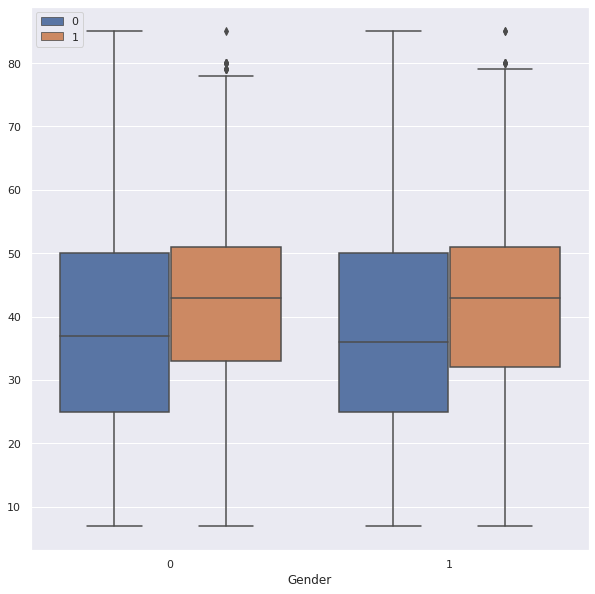

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x = df["Gender"], y = df["Age"].values, hue=df["satisfaction"])
plt.legend(loc='upper left')
plt.show()

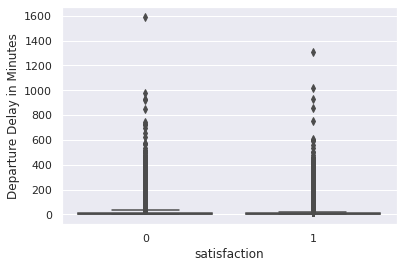

In [ ]:
sns.boxplot(y = df["Departure Delay in Minutes"], x=df["satisfaction"])
plt.show()

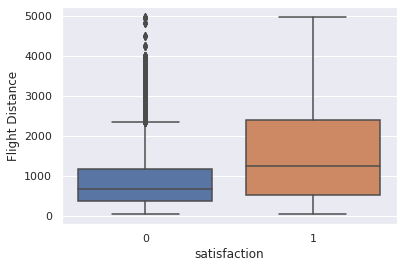

In [ ]:
sns.boxplot(y = df["Flight Distance"], x=df["satisfaction"])
plt.show()

## Distplot

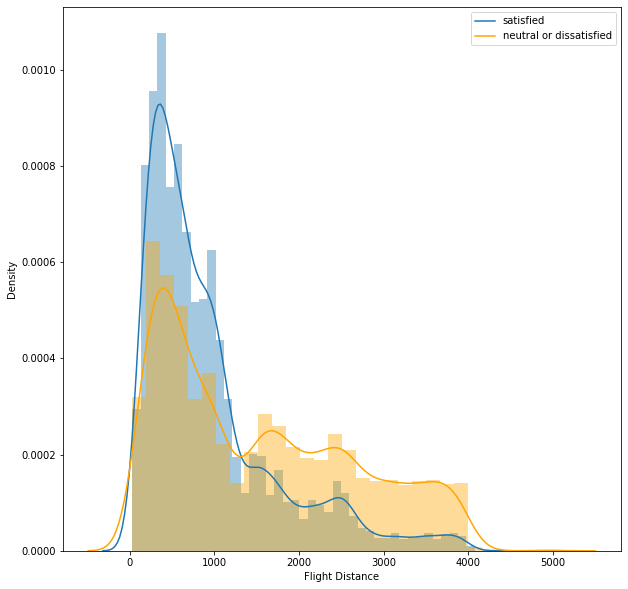

In [ ]:
plt.figure(figsize = (10,10))
sns.distplot(df[df.satisfaction == 0]["Flight Distance"])
sns.distplot(df[df.satisfaction == 1]["Flight Distance"], color="orange");
labels = ['satisfied', 'neutral or dissatisfied']
plt.legend(labels, loc="upper right");

# Outliers

In [ ]:
#%% Outlier
x = df.drop(["satisfaction"], axis = 1)
y = df.satisfaction

outlier_threshold = -1.3
columns = x.columns.tolist()

clf = LocalOutlierFactor()
#-1 = outlier 1 = inlier
outlier_predict = clf.fit_predict(x)
feature_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = feature_score

filter_outlier = outlier_score["score"] < outlier_threshold
outliers_index = outlier_score[filter_outlier].index.tolist()
print(f"Outlier Count: {len(outliers_index)} \nSample Count: {len(x)}\nOutlier Count/Sample Count: {round(len(outliers_index) / len(x),3)}")
#drop outliers
x = x.drop(outliers_index)
y = y.drop(outliers_index).values

Outlier Count: 1122 
Sample Count: 103904
Outlier Count/Sample Count: 0.011


# Standardization

In [ ]:
# random state = the result of mixing is the same every time.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

data_df = x.copy()
data_df["satisfaction"] = y
data_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,5,3,5,5,4,3,4,4,5,5,25,0
1,0,0,25,1,2,235,3,2,3,1,3,1,1,1,5,3,1,4,1,1,0
2,1,1,26,1,2,1142,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1
3,1,1,25,1,2,562,2,5,5,2,2,2,2,2,5,3,1,4,2,11,0
4,0,1,61,1,2,214,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1


In [ ]:
for train_index, test_index in split.split(data_df, data_df["satisfaction"]):
    strat_train_set = data_df.iloc[train_index]
    strat_test_set = data_df.iloc[test_index]

In [ ]:
train_prop = strat_train_set["satisfaction"].sum() / len(strat_train_set)
test_prop = strat_test_set["satisfaction"].sum() / len(strat_test_set)
print(f"Proportion of satisfaction in train set: {round(train_prop,3)}\nProportion of satisfaction in test set: {round(test_prop,3)}")

Proportion of satisfaction in train set: 0.434
Proportion of satisfaction in test set: 0.434


In [ ]:
#Split
x_train, y_train = strat_train_set.drop("satisfaction", axis=1), strat_train_set["satisfaction"]
x_test, y_test = strat_test_set.drop("satisfaction", axis=1), strat_test_set["satisfaction"]
x_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes
7751,0,0,23,1,0,583,3,5,3,4,3,4,4,5,4,5,3,4,4,3
94807,1,1,28,1,0,853,2,4,4,2,2,2,2,1,1,2,4,2,2,0
89355,0,1,62,1,0,266,4,5,5,4,4,4,4,5,2,3,4,4,4,7
95229,1,1,60,1,2,1589,4,4,4,5,4,5,5,5,5,5,4,5,4,0
62731,0,1,42,1,2,421,5,5,2,2,5,4,3,3,3,3,3,3,4,0


In [ ]:
# (x - mean) / std
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Helper Functions

## Confusion Matrix Plot

In [ ]:
def createLabels(conf_matrix, group_names):
  group_counts = ["{0:0.0f}".format(value) for value in
                  conf_matrix.flatten()]
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)

  return labels

In [ ]:
def plotConfusionMatrix(tuned_model, x_train, x_test, y_train, y_test):
  y_pred_test = tuned_model.predict(x_test)
  y_pred_train = tuned_model.predict(x_train)
  conf_matrix_train = confusion_matrix(y_train, y_pred_train)
  conf_matrix_test = confusion_matrix(y_test, y_pred_test)

  group_names = ["True Negative","False Positive","False Negative","True Positive"]

  labels = createLabels(conf_matrix_train, group_names)
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8), sharey=True)
  sns.heatmap(conf_matrix_train, annot=labels,cmap='Blues', fmt="", linewidths=.5, ax = ax[0])
  ax[0].set_xlabel('Predicted labels');
  ax[0].set_ylabel('True labels'); 
  ax[0].set_title("Train set confusion matrix");

  labels = createLabels(conf_matrix_test, group_names)
  sns.heatmap(conf_matrix_test, annot=labels,cmap='Blues', fmt="", linewidths=.5, ax = ax[1])
  ax[1].set_xlabel('Predicted labels');
  ax[1].set_ylabel('True labels'); 
  ax[1].set_title("Test set confusion matrix");

  plt.show()
  return y_pred_test

## Performance Metrics Function

In [ ]:
def performanceMetrics(grid, y_test, y_pred_test, performance_df):
  train_accuracy = grid.best_score_
  accuracy = accuracy_score(y_test, y_pred_test)
  precision = precision_score(y_test, y_pred_test)
  recall = recall_score(y_test, y_pred_test)
  f1_score_result = f1_score(y_test ,y_pred_test)
  roc_auc = roc_auc_score(y_test ,y_pred_test)
  time = grid.refit_time_
  fpr, tpr, _ = roc_curve(y_test, y_pred_test)
  result = {"Train Accuracy": train_accuracy, "Test Accuracy":accuracy, "Precision":precision, "Recall":recall, 
                "F1 Score":f1_score_result, "Roc Auc Score":roc_auc ,"Fitting Time":time, "fpr":fpr, "tpr":tpr}
  
  performance_df.loc[len(performance_df.index)]	= result
  
  return performance_df

## Tune Function

In [ ]:
def tune_function(x_train, x_test, y_train, y_test, param_grid, model, cv = [(slice(None), slice(None))]):
    grid = GridSearchCV(model, param_grid, cv = cv, verbose = 1, n_jobs = 8)
    grid.fit(x_train, y_train)
    print("Best training score: {:.4f} with parameters: {}".format(grid.best_score_, grid.best_params_))
    print("Train Score {:.4f}, Test Score {:.4f}".format(grid.score(x_train,y_train), grid.score(x_test,y_test)))
    print("Seconds used for refitting the best model on the train dataset: {:.4f}".format(grid.refit_time_))
    
    return grid

## Feature Importance Plot

In [ ]:
def FeatureImportancePlot(feature, importance):
  fi = pd.DataFrame({'Feature':feature,
       'Importance':importance}).sort_values(by = "Importance", ascending = True).reset_index(drop = True)
       
  fig = px.bar(fi, x='Importance', y='Feature',orientation='h',color='Importance')
  fig.show()
  return fi

# Train Models

In [ ]:
performance_columns = ['Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','Roc Auc Score','Fitting Time','fpr','tpr']
performance_df = pd.DataFrame(columns = performance_columns)

## Random Forest

### Without Cross-Validation

In [ ]:
RF = RandomForestClassifier(random_state=42)
RF_grid = tune_function(x_train, x_test, y_train, y_test, {}, RF)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   11.1s finished


Best training score: 1.0000 with parameters: {}
Train Score 1.0000, Test Score 0.9632
Seconds used for refitting the best model on the train dataset: 8.0929


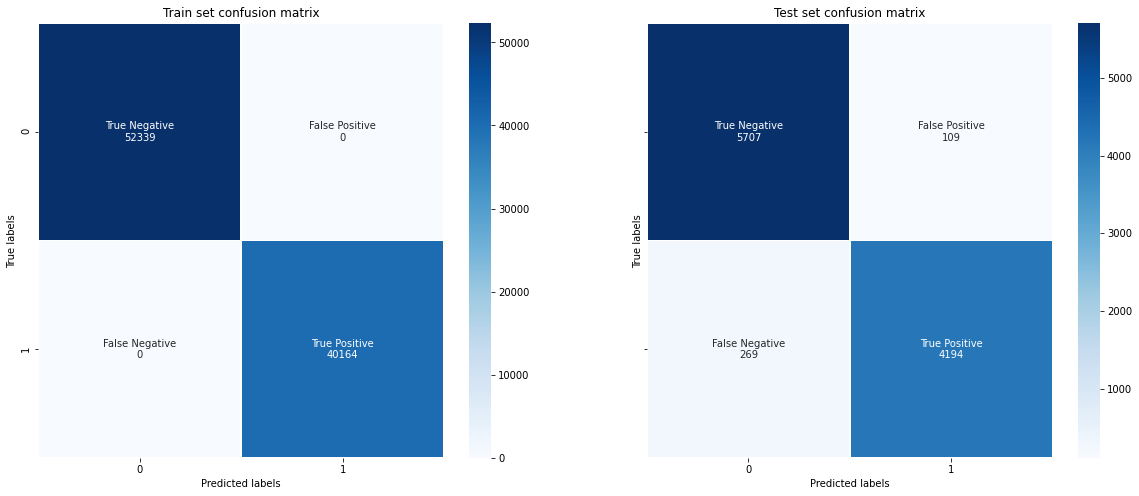

In [ ]:
y_pred_test = plotConfusionMatrix(RF_grid, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(RF_grid, y_test, y_pred_test, performance_df)

### Cross-Validation

In [ ]:
n_estimators = [5, 10, 15, 20]
criterion = ["gini", "entropy"]
max_depth =  [3, 5, 7, 9, 11]
param_grid_RF = dict(n_estimators = n_estimators,  criterion = criterion, max_depth = max_depth)

In [ ]:
RF = RandomForestClassifier(random_state=42)
RF_grid = tune_function(x_train, x_test, y_train, y_test, param_grid_RF, RF, 10)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  3.5min finished


Best training score: 0.9513 with parameters: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 15}
Train Score 0.9563, Test Score 0.9517
Seconds used for refitting the best model on the train dataset: 0.9556


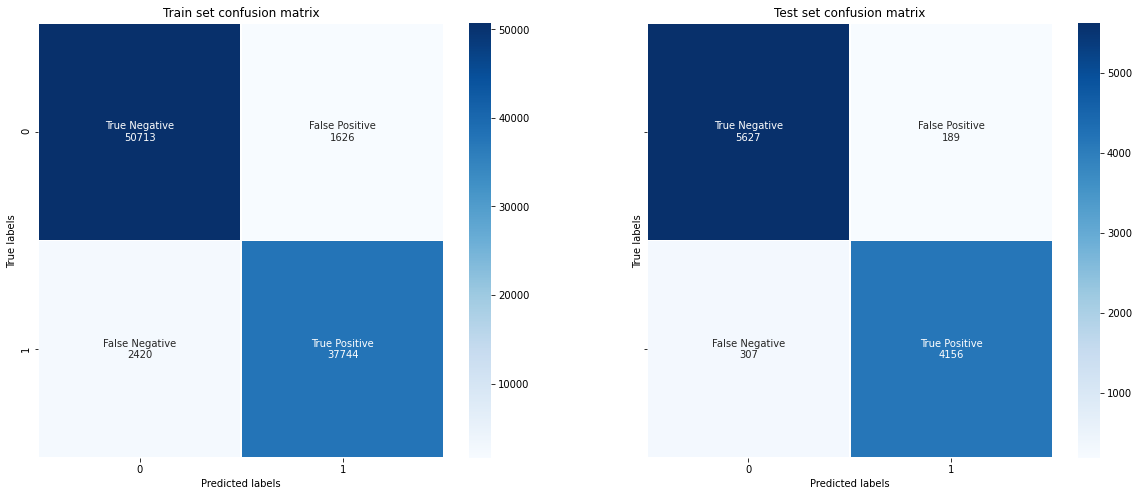

In [ ]:
y_pred_test = plotConfusionMatrix(RF_grid, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(RF_grid, y_test, y_pred_test, performance_df)

### Feature Importance

In [ ]:
fi_rf = FeatureImportancePlot(df.columns[:-1], RF_grid.best_estimator_.feature_importances_)

## Logistic Regression

### Without Cross-Validation

In [ ]:
logistic_regression = LogisticRegression(random_state=42)
logistic_grid = tune_function(x_train, x_test, y_train, y_test, {}, logistic_regression)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.2s finished


Best training score: 0.8756 with parameters: {}
Train Score 0.8756, Test Score 0.8759
Seconds used for refitting the best model on the train dataset: 0.2349


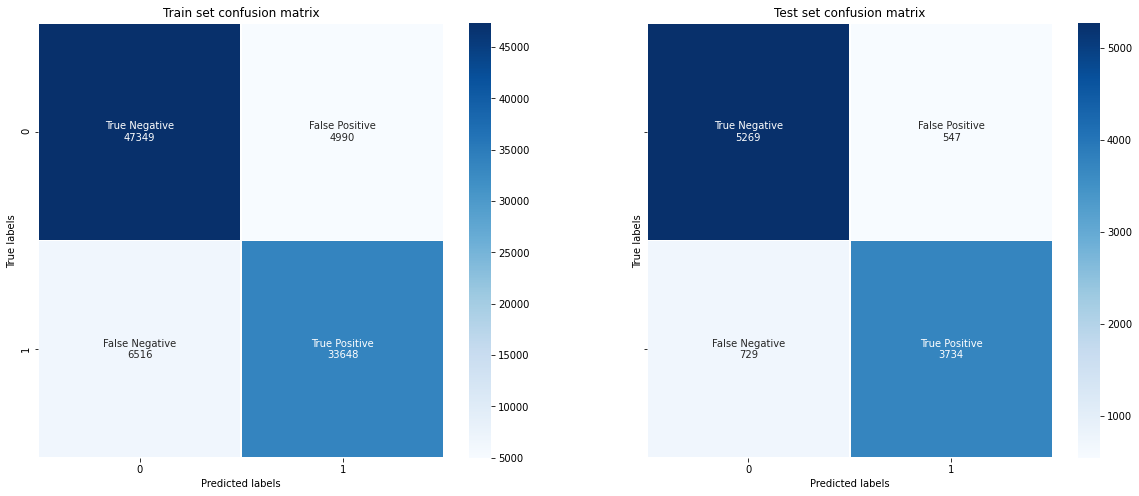

In [ ]:
y_pred_test_logistic = plotConfusionMatrix(logistic_grid, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(logistic_grid, y_test, y_pred_test_logistic, performance_df)

### Cross-Validation

In [ ]:
penalty = ["l1", "l2", "elasticnet"]
C = np.logspace(-4, 4, 20)
solver = ["liblinear", "sag", "saga"]
param_grid_logistic = dict(penalty = penalty,  C = C, solver = solver)

In [ ]:
logistic_regression = LogisticRegression(random_state=42)
logistic_grid = tune_function(x_train, x_test, y_train, y_test, param_grid_logistic, logistic_regression, 10)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done 1800 out of 1800 | elapsed:  6.2min finished


Best training score: 0.8757 with parameters: {'C': 0.03359818286283781, 'penalty': 'l1', 'solver': 'saga'}
Train Score 0.8757, Test Score 0.8756
Seconds used for refitting the best model on the train dataset: 0.4642


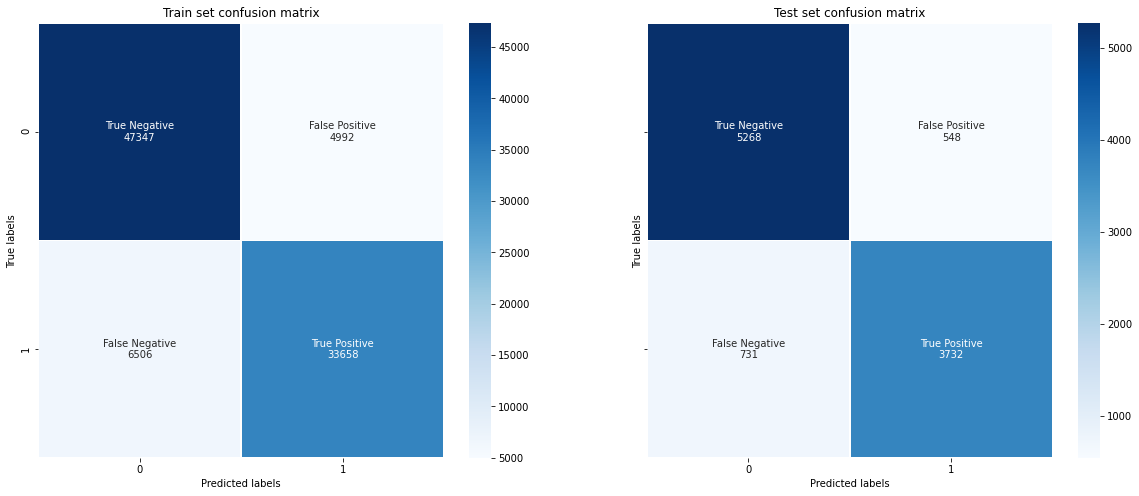

In [ ]:
y_pred_test_logistic = plotConfusionMatrix(logistic_grid, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(logistic_grid, y_test, y_pred_test_logistic, performance_df)

###Coefficient

In [ ]:
fcoef_log = pd.DataFrame({'Feature':df.columns[:-1],
       'Importance':logistic_grid.best_estimator_.coef_[0]}).sort_values(by = "Importance",ascending = True).reset_index(drop = True)
       
fig = px.bar(fcoef_log, x='Importance', y='Feature',orientation='h',color='Importance')
fig.show()

## Light-GBM

### Without Cross-Validation

In [ ]:
lgm_model = lgb.LGBMClassifier()
lgm_grid = tune_function(x_train, x_test, y_train, y_test, {}, lgm_model)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    2.2s finished


Best training score: 0.9657 with parameters: {}
Train Score 0.9657, Test Score 0.9648
Seconds used for refitting the best model on the train dataset: 1.4449


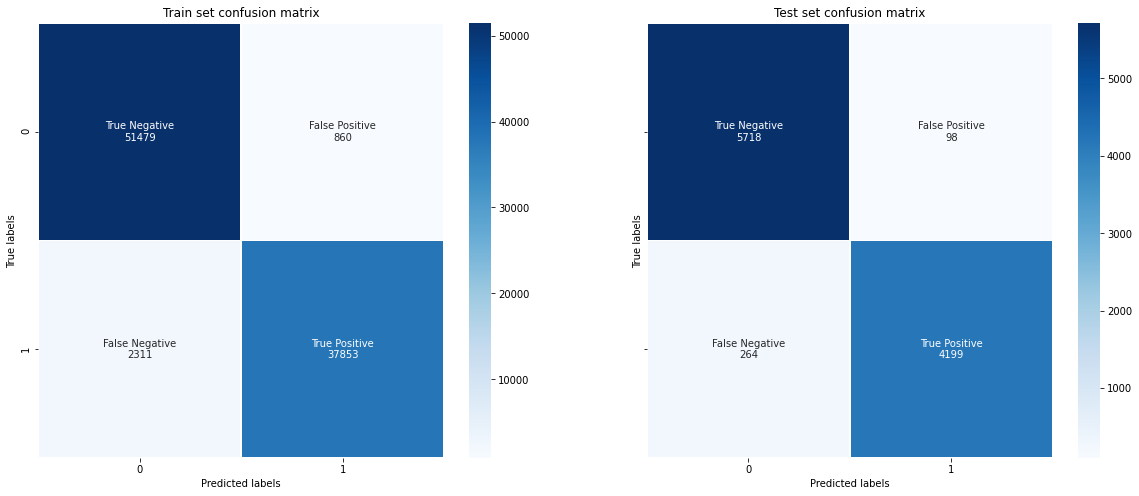

In [ ]:
y_pred_test_lgm = plotConfusionMatrix(lgm_grid, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(lgm_grid, y_test, y_pred_test_lgm, performance_df)

### Cross-Validation

In [ ]:
num_leaves = range(1,10, 4)
max_dept = range(1, 10, 4)
learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
min_data_in_leaf = range(1, 11, 5)
param_grid_lgm = dict(num_leaves = num_leaves,  max_dept = max_dept, 
                           learning_rate = learning_rate, min_data_in_leaf = min_data_in_leaf)

In [ ]:
lgm_model = lgb.LGBMClassifier()
lgm_grid = tune_function(x_train, x_test, y_train, y_test, param_grid_lgm, lgm_model, 10)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  47 tasks      | elapsed:   31.3s
[Parallel(n_jobs=8)]: Done 200 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 450 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 800 tasks      | elapsed:  8.3min
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:  9.2min finished


Best training score: 0.9605 with parameters: {'learning_rate': 0.5, 'max_dept': 1, 'min_data_in_leaf': 1, 'num_leaves': 9}
Train Score 0.9607, Test Score 0.9608
Seconds used for refitting the best model on the train dataset: 0.9177


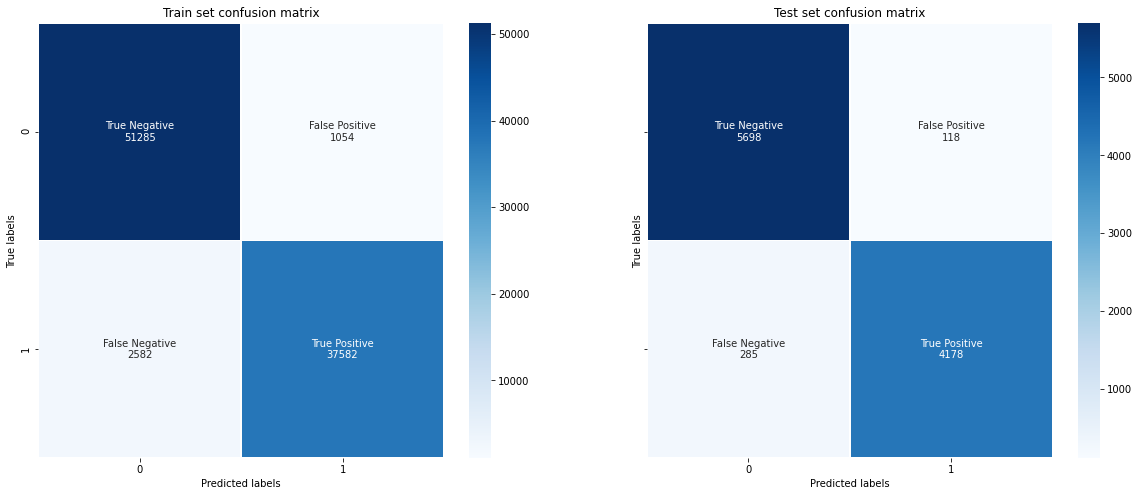

In [ ]:
y_pred_test_lgm = plotConfusionMatrix(lgm_grid, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(lgm_grid, y_test, y_pred_test_lgm, performance_df)

###Feature Importance

In [ ]:
lgm_importance = lgm_grid.best_estimator_.feature_importances_ / sum(lgm_grid.best_estimator_.feature_importances_)
fi_lgm = FeatureImportancePlot(df.columns[:-1], lgm_importance)

# Elimination Function

In [ ]:
def FeatureElimination(importance_matrix, threshold, strat_train_set, strat_test_set):
  x_train, y_train = strat_train_set.drop("satisfaction", axis=1), strat_train_set["satisfaction"]
  x_test, y_test = strat_test_set.drop("satisfaction", axis=1), strat_test_set["satisfaction"]

  x_train = x_train.loc[:, importance_matrix[importance_matrix["Importance"] > threshold]["Feature"]]
  x_test = x_test.loc[:, importance_matrix[importance_matrix["Importance"] > threshold]["Feature"]]

  scaler = StandardScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  return x_train, x_test

# Feature Elimination For Random Forest

In [ ]:
rf_threshold = 0.023
x_train, x_test = FeatureElimination(fi_rf, rf_threshold, strat_train_set, strat_test_set)

In [ ]:
RF_Fs = RandomForestClassifier(random_state=42)
RF_grid_Fs = tune_function(x_train, x_test, y_train, y_test, param_grid_RF, RF_Fs, 10)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   56.8s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:  2.1min finished


Best training score: 0.9429 with parameters: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 15}
Train Score 0.9449, Test Score 0.9422
Seconds used for refitting the best model on the train dataset: 0.4996


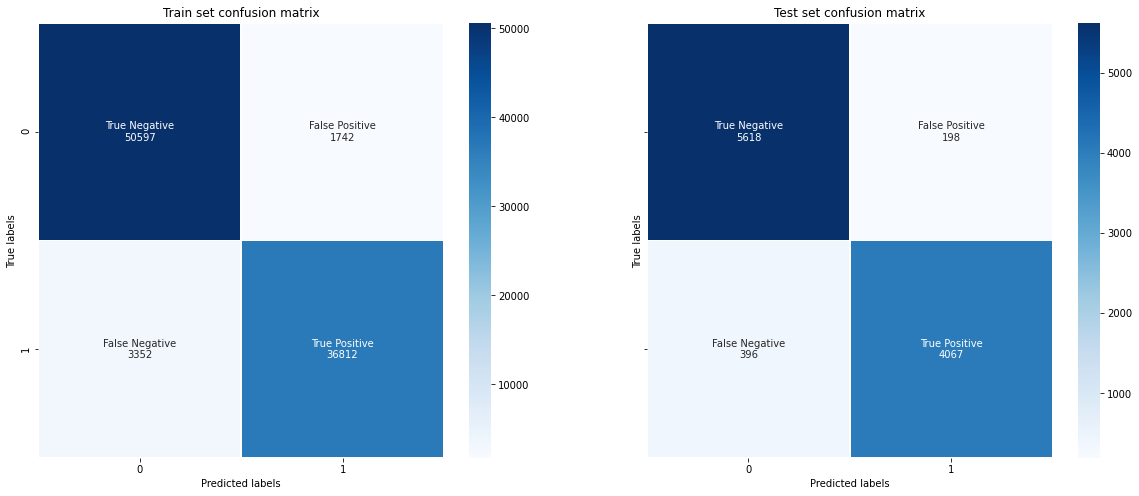

In [ ]:
y_pred_test_RF = plotConfusionMatrix(RF_grid_Fs, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(RF_grid_Fs, y_test, y_pred_test, performance_df)

In [ ]:
fi_rf_fs = FeatureImportancePlot(fi_rf[fi_rf["Importance"] > rf_threshold]["Feature"], RF_grid_Fs.best_estimator_.feature_importances_)

# Feature Elimination For Light-GBM

In [ ]:
lgm_threshold = 0.03875
x_train, x_test = FeatureElimination(fi_lgm, lgm_threshold, strat_train_set, strat_test_set)

In [ ]:
lgm_model = lgb.LGBMClassifier()
lgm_grid_fs = tune_function(x_train, x_test, y_train, y_test, param_grid_lgm, lgm_model, 10)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  49 tasks      | elapsed:   22.8s
[Parallel(n_jobs=8)]: Done 200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 450 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 800 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:  6.4min finished


Best training score: 0.9506 with parameters: {'learning_rate': 0.5, 'max_dept': 1, 'min_data_in_leaf': 1, 'num_leaves': 9}
Train Score 0.9544, Test Score 0.9509
Seconds used for refitting the best model on the train dataset: 0.6401


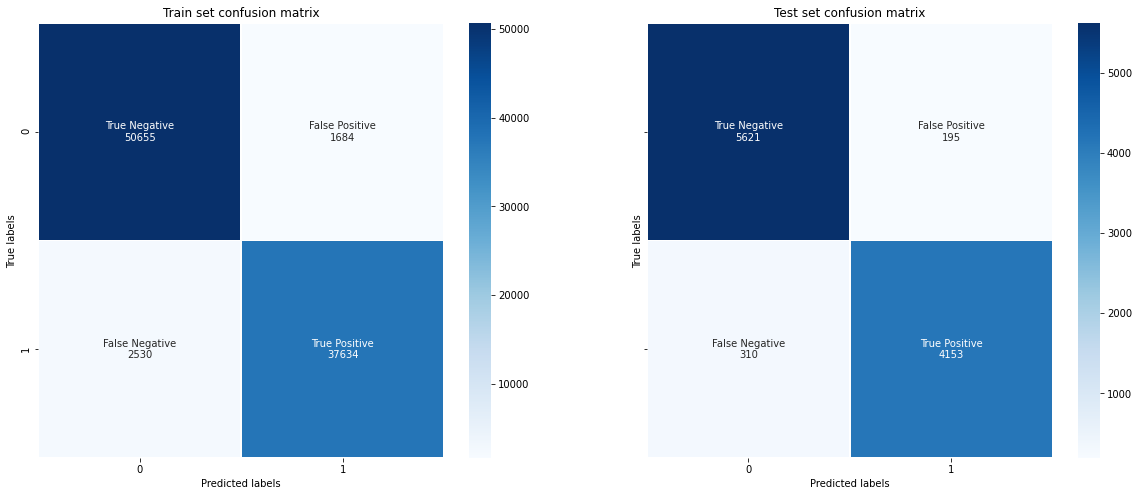

In [ ]:
y_pred_test_lgm_fs = plotConfusionMatrix(lgm_grid_fs, x_train, x_test, y_train, y_test)

In [ ]:
performance_df = performanceMetrics(lgm_grid_fs, y_test, y_pred_test_lgm_fs, performance_df)

In [ ]:
lgm_importance_fs = lgm_grid_fs.best_estimator_.feature_importances_ / sum(lgm_grid_fs.best_estimator_.feature_importances_)
fi_lgm_fs = FeatureImportancePlot(fi_lgm[fi_lgm["Importance"] > lgm_threshold]["Feature"], lgm_importance_fs)

# Performance Plots

In [ ]:
performance_df.rename(index={0:'Random Forest Without Cross-Validation',
                             1:'Random Forest With Cross-Validation',
                             2:'Logistic Regression Without Cross-Validation',
                             3:'Logistic Regression With Cross-Validation', 
                             4:"LightGBM Without Cross-Validation",
                             5:"LightGBM With Cross-Validation",
                             6:"Random Forest With Feature Selection",
                             7:"LightGBM With Feature Selection"
                             }, inplace=True)
performance_df.iloc[:, :-2]

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Roc Auc Score,Fitting Time
Random Forest Without Cross-Validation,1.000000,0.963226,0.974669,0.939727,0.956879,0.960493,8.092876
Random Forest With Cross-Validation,0.951277,0.951746,0.956502,0.931212,0.943688,0.949358,0.955622
Logistic Regression Without Cross-Validation,0.875615,0.875863,0.872226,0.836657,0.854071,0.871303,0.234904
Logistic Regression With Cross-Validation,0.875669,0.875572,0.871963,0.836209,0.853712,0.870993,0.464226
LightGBM Without Cross-Validation,0.965720,0.964783,0.977193,0.940847,0.958676,0.961998,1.444933
LightGBM With Cross-Validation,0.960499,0.960794,0.972533,0.936142,0.953990,0.957926,0.917740
Random Forest With Feature Selection,0.942942,0.951746,0.956502,0.931212,0.943688,0.949358,0.499602
LightGBM With Feature Selection,0.950639,0.950871,0.955152,0.930540,0.942685,0.948506,0.640085


In [ ]:
fig = px.bar(performance_df, x='Test Accuracy', y = performance_df.index, 
             orientation='h',color='Test Accuracy', labels={'y':'Models'})
fig.show()

In [ ]:
fig = px.bar(performance_df, x='F1 Score', y = performance_df.index, 
             orientation='h',color='F1 Score', labels={'y':'Models'})
fig.show()

# Roc Curve Plots

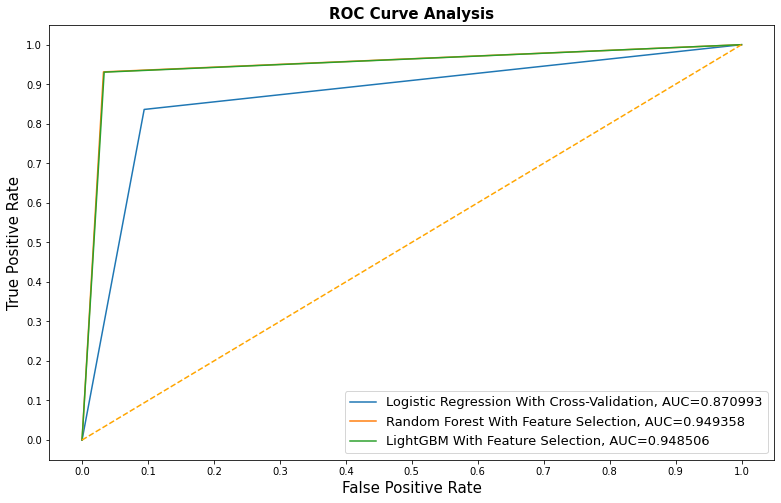

In [ ]:
fig = plt.figure(figsize=(13,8))
for i in performance_df.iloc[[3, 6, 7], :].index:
    plt.plot(performance_df.loc[i]['fpr'], 
             performance_df.loc[i]['tpr'], 
             label="{}, AUC={:.6f}".format(i, performance_df.loc[i]['Roc Auc Score']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()